# Часть 1
## Установка SyntaxNet
Так как компьютера с unix не было решено использовать docker.
Для облегчения работы был написан скрипт создания image на основе image SyntaxNet
```
FROM tensorflow/syntaxnet

COPY UD_Russian /opt/tensorflow/syntaxnet/UD_Russian
COPY UD_Chinese /opt/tensorflow/syntaxnet/UD_Chinese 
COPY scripts /opt/tensorflow/syntaxnet/my_script

RUN pip install nltk
```
## Прогон корпусов
После этого, подключаемся к контейнеру и запускаем скрипты для прогона наших корпусов с теггером и без него.
Скрипты были написаны на основе syntaxnet/demo.sh
Скрипт для прогона с теггером SyntaxNet:
```
#!/bin/bash
PARSER_EVAL=bazel-bin/syntaxnet/parser_eval
CONTEXT=syntaxnet/models/parsey_universal/context.pbtxt
if [[ "$1" == "--conll" ]] && INPUT_FORMAT=stdin-conll || INPUT_FORMAT=stdin
MODEL_DIR=$1

$PARSER_EVAL \
  --input=$INPUT_FORMAT \
  --output=stdout-conll \
  --hidden_layer_sizes=64 \
  --arg_prefix=brain_morpher \
  --graph_builder=structured \
  --task_context=$CONTEXT \
  --resource_dir=$MODEL_DIR \
  --model_path=$MODEL_DIR/morpher-params \
  --slim_model \
  --batch_size=1024 \
  --alsologtostderr \
  | \
  $PARSER_EVAL \
  --input=stdin-conll \
  --output=stdout-conll \
  --hidden_layer_sizes=64 \
  --arg_prefix=brain_tagger \
  --graph_builder=structured \
  --task_context=$CONTEXT \
  --resource_dir=$MODEL_DIR \
  --model_path=$MODEL_DIR/tagger-params \
  --slim_model \
  --batch_size=1024 \
  --alsologtostderr \
  | \
  $PARSER_EVAL \
  --input=stdin-conll \
  --output=stdout-conll \
  --hidden_layer_sizes=512,512 \
  --arg_prefix=brain_parser \
  --graph_builder=structured \
  --task_context=$CONTEXT \
  --resource_dir=$MODEL_DIR \
  --model_path=$MODEL_DIR/parser-params \
  --slim_model \
  --batch_size=1024 \
  --alsologtostderr
```
Скрипты будут в высланном архивет.
После прогона получили 4 conll файла(так же будут в архиве)
Так же для упрощения запуска сриптов 4 раза был написан скрипт запуска:
```
#!/bin/bash
cat UD_Chinese/ud-test.conllu | my_script/without_tagger.sh --conll UD_Chinese/Chinese > chinese_tagger.conll | \
cat UD_Chinese/ud-test.conllu | my_script/tagger.sh --conll UD_Chinese/Chinese > chinese_without_tagger.conll | \
cat UD_Russian/ud-test.conllu | my_script/without_tagger.sh --conll UD_Russian/Russian > russian_tagger.conll | \
cat UD_Russian/ud-test.conllu | my_script/tagger.sh --conll UD_Russian/Russian > russian_without_tagger.conll
```

# Часть 2

In [39]:
import sys
import nltk
import math
import time
import collections
import itertools
from itertools import cycle, islice
import math
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
import nltk
import numpy as np

def conll_parser(conll):
    # Counters
    tokens = 0
    words = collections.Counter()
    tags = collections.Counter()
    attrs = collections.Counter()
    deps = collections.Counter()
    
    for line in conll:
        first_symb = line.split('\t')[0]
        if first_symb.isdigit(): # строка начинающаяся с цифры
            
            word = line.split('\t')[1] # слово
            words[word] += 1 
            tokens += 1
            
            tag = line.split('\t')[3] # часть речи
            tags[tag] += 1
            
            attributes = line.split('\t')[5] # атрибуты
            
            # парсим атрибуты            
            for look_for_attr in ['Animacy', 'Aspect', 'Case', 'Definite', 'Degree',
                         'Evident', 'Gender', 'Mood', 'NumType', 'Number',
                         'Person', 'Polarity', 'Polite', 'PronType', 'Tense',
                         'VerbForm', 'Voice']:
                index_of_attr = attributes.find(look_for_attr)
                if index_of_attr >= 0:
                    index_of_attr += len(look_for_attr)
                    cut_string = attributes[index_of_attr:]
                    index_start = cut_string.find('=')
                    index_start += 1
                    index_end = cut_string.find('|')
                    if index_end < 0:
                        index_end = cut_string.find('\t')
                    if index_end >= 0:
                        value = cut_string[index_start:index_end]
                        attr_name = look_for_attr + ':' + value
                        attrs[attr_name] += 1
                        
            # парсим бинарные атрибуты
            for look_for_attr in ['Abbr', 'Foreign', 'Poss', 'Reflex']:
                index_of_attr = attributes.find(look_for_attr)
                if index_of_attr >= 0:
                    index_of_attr += len(look_for_attr)
                    index_of_attr += 1
                    tmp = ''
                    if look_for_attr != 'Foreign':
                        tmp = attributes[index_of_attr:index_of_attr + len('Yes')]
                    else:
                        tmp = attributes[index_of_attr:index_of_attr + len('Foreign')]
                    if tmp == 'Yes' or tmp == 'Foreign':
                        attrs[look_for_attr] += 1
            
            dep = line.split('\t')[7] # зависимости
            deps[dep] += 1 
    
    return tokens, words, tags, attrs, deps

In [119]:
def pos_statistic(tag_count):
    tags = []
    counts = []
    norms = []
    for tag, count in tag_count.items():
        tags.append(tag)
        counts.append(count)
    table = pd.DataFrame(data={'Pos' : tags, 'Count' : counts})
    for i in counts:
        norms.append(float(i) / sum(table.Count))
    table['Norm'] = norms
    table = table[['Pos', 'Count','Norm']]
    return table

In [120]:
def attr_statistic(attr_count):
    attrs = []
    counts = []
    norms = []
    for attr, count in attr_count.items():
        attrs.append(attr)
        counts.append(count)
    table = pd.DataFrame(data={'Attribute' : attrs, 'Count' : counts})
    for i in counts:
        norms.append(float(i) / sum(table.Count))
    table['Norm'] = norms
    table = table[['Attribute', 'Count','Norm']]
    return table

In [121]:
def dep_statistic(dep_count):
    deps = []
    counts = []
    norms = []
    for dep, count in dep_count.items():
        deps.append(dep)
        counts.append(count)
    table = pd.DataFrame(data={'Dep' : deps, 'Count' : counts})
    for i in counts:
        norms.append(float(i) / sum(table.Count))
    table['Norm'] = norms
    table = table[['Dep', 'Count','Norm']]
    return table

In [122]:
def plot_statistic(data, column, title):
    my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k', 'black', 'orange', 'purple', 'gray']), None, len(data)))
    data.plot(x=column, y='Norm', kind='bar', figsize=(5, 5), grid=True, title=title, legend=False, color=my_colors)
    plt.show()

In [123]:
import io
%matplotlib inline

## Русский язык

POS - 81.77%

LAS - 77.71%
UAS - 81.75%

In [124]:
connl_rustest = io.open("lab2/UD_Russian/ud-test.conllu", "r", encoding = "utf-8")
connl_rustrain = io.open("lab2/UD_Russian/ud-train.conllu", "r", encoding = "utf-8")
connl_file_rustest = connl_rustest.readlines()
connl_file_rustrain = connl_rustrain.readlines()
connl_rustest.close()
connl_rustrain.close()

In [125]:
rustest_token_count, rustest_word_count, rustest_tag_count, rustest_attr_count, rustest_dep_count = conll_parser(connl_file_rustest)
rustrain_token_count, rustrain_word_count, rustrain_tag_count, rustrain_attr_count, rustrain_dep_count = conll_parser(connl_file_rustrain)

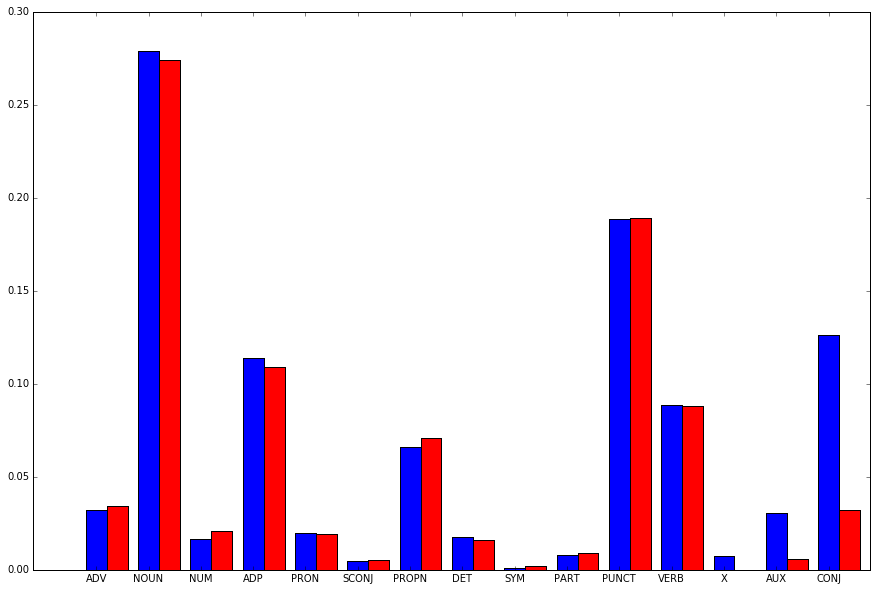

In [126]:
rustest_pos = pos_statistic(rustest_tag_count)
rustrain_pos = pos_statistic(rustrain_tag_count)

plt.figure(figsize=(15,10))
ax = plt.gca()
patches, labels = ax.get_legend_handles_labels()
locs = np.arange(1, len(rustrain_pos.Pos.values))
width = 0.4
Y = np.arange(len(locs))
labels = []
for i in rustrain_pos.Pos.values:
    string = str(i)
    plt.bar(locs, rustest_pos.Norm.values, width=width, color='blue')
    plt.bar(locs + width, rustrain_pos.Norm.values[:15], width=width, color='red')
    labels.append(string)
plt.xticks(locs + width*0.5, labels)
plt.show()

In [127]:
connl_rus = io.open("lab2/results/russian_tagger.conll", "r", encoding = "utf-8")
connl_file_rus = connl_rus.readlines()
connl_rus.close()

In [128]:
rus_token_count, rus_word_count, rus_tag_count, rus_attr_count, rus_dep_count = conll_parser(connl_file_rus)

In [129]:
print "Количество токенов: " + str(rus_token_count)

Количество токенов: 9573


In [130]:
print "Количество уникальных токенов: " + str(len(rus_word_count.keys()))

Количество уникальных токенов: 4876


In [131]:
pos_statistic(rus_tag_count)

,Pos,Count,Norm
0,ADV,203,0.021205
1,NOUN,2466,0.257599
2,ADP,1080,0.112817
3,PRON,182,0.019012
4,SCONJ,65,0.006790
5,PROPN,736,0.076883
6,DET,163,0.017027
7,SYM,10,0.001045
8,PART,37,0.003865
9,PUNCT,1806,0.188656


Case
  Attribute  Count      Norm
0       Acc    610  0.117806
1       Loc    697  0.134608
2       Nom   1530  0.295481
3       Ins    359  0.069332
4       Dat    181  0.034956
5       Gen   1801  0.347818


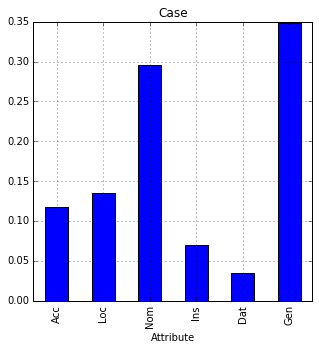

Animacy
  Attribute  Count      Norm
0      Inan   4117  0.834414
1      Anim    817  0.165586


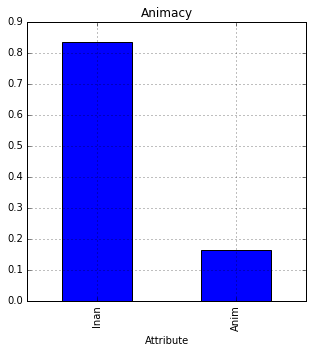

Gender
  Attribute  Count      Norm
0      Neut    648  0.150035
1       Fem   1299  0.300764
2      Masc   2372  0.549201


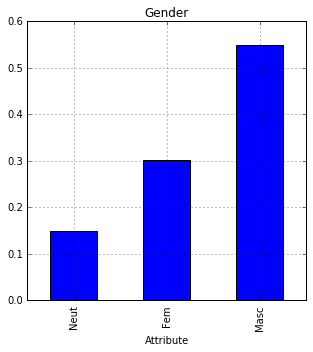

Number
  Attribute  Count      Norm
0      Sing   4469  0.795196
1      Plur   1151  0.204804


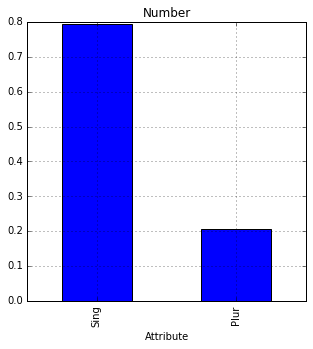

Person
  Attribute  Count      Norm
0         1     13  0.038123
1         3    328  0.961877


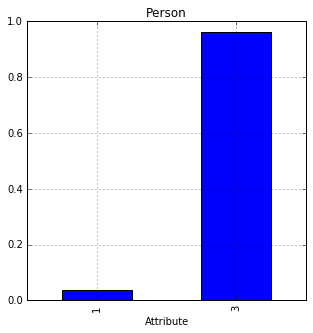

Tense
  Attribute  Count      Norm
0      Past    541  0.688295
1       Fut     11  0.013995
2      Pres    234  0.297710


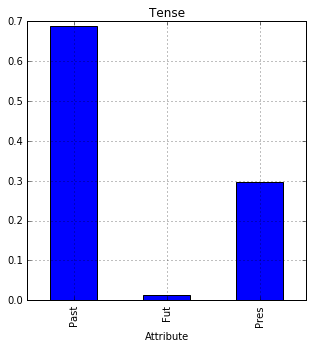

Aspect
  Attribute  Count      Norm
0       Imp    511  0.573513
1      Perf    380  0.426487


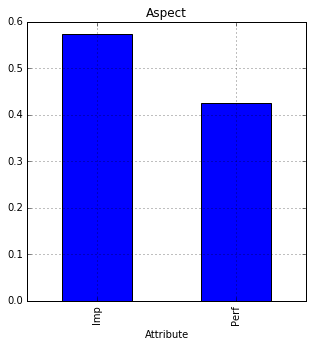

Voice
  Attribute  Count  Norm
0      Pass    132  0.75
1       Act     44  0.25


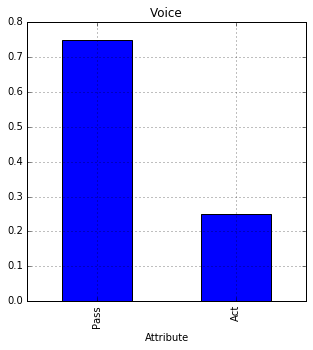

In [132]:
attr_only_spec = {}
for attr in ['Animacy', 'Aspect', 'Case', 'Definite', 'Degree',\
                         'Evident', 'Gender', 'Mood', 'NumType', 'Number',\
                         'Person', 'Polarity', 'Polite', 'PronType', 'Tense',\
                         'VerbForm', 'Voice']:
    spec_dict = {}
    for k,v in rus_attr_count.items():
        if k.find(attr) != -1:
            new_key = k[k.find(':')+1:] # taking second part of name, attribute specific
            spec_dict[new_key] = v
    if len(spec_dict) > 1: # only attributes with more than 1 value
        attr_only_spec[attr] = spec_dict
for k,v in attr_only_spec.items():  
    df = attr_statistic(attr_only_spec[k])
    print(k)
    print(df)
    plot_statistic(df, 'Attribute', k)

In [133]:
dep_statistic(rus_dep_count)

,Dep,Count,Norm
0,cc,273,0.028518
1,list,48,0.005014
2,cc:preconj,16,0.001671
3,ccomp,24,0.002507
4,remnant,5,0.000522
5,nsubjpass,72,0.007521
6,conj,379,0.039591
7,dobj,222,0.023190
8,neg,36,0.003761
9,discourse,42,0.004387


## Китайский язык

POS - 90.89%

LAS - 71.24%
UAS - 76.71%

In [134]:
connl_chtest = io.open("lab2/UD_Chinese/ud-test.conllu", "r", encoding = "utf-8")
connl_chtrain = io.open("lab2/UD_Chinese/ud-train.conllu", "r", encoding = "utf-8")
connl_file_chtest = connl_chtest.readlines()
connl_file_chtrain = connl_chtrain.readlines()
connl_chtest.close()
connl_chtrain.close()

In [135]:
chtest_token_count, chtest_word_count, chtest_tag_count, chtest_attr_count, chtest_dep_count = conll_parser(connl_file_chtest)
chtrain_token_count, chtrain_word_count, chtrain_tag_count, chtrain_attr_count, chtrain_dep_count = conll_parser(connl_file_chtrain)

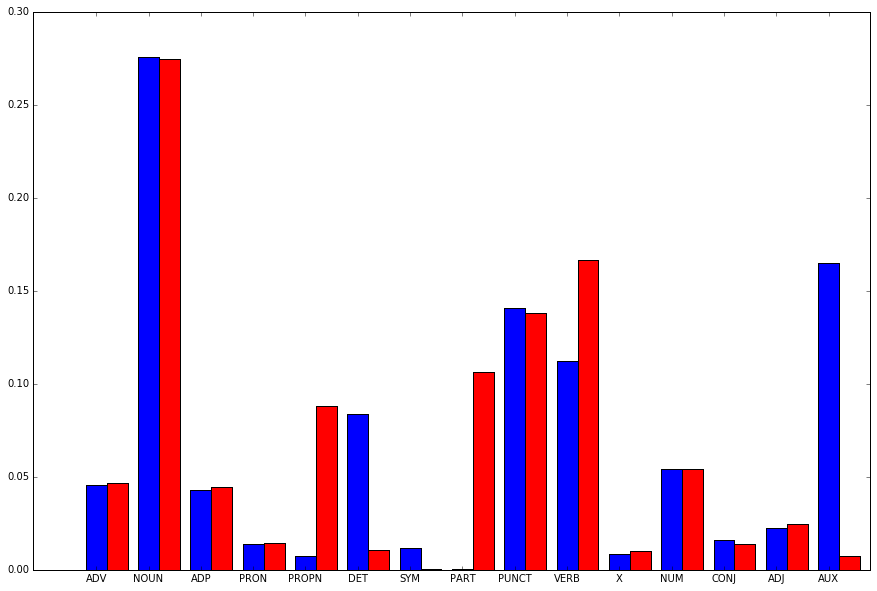

In [139]:
chtest_pos = pos_statistic(chtest_tag_count)
chtrain_pos = pos_statistic(chtrain_tag_count)

plt.figure(figsize=(15,10))
patches, labels = ax.get_legend_handles_labels()
locs = np.arange(1, len(chtrain_pos.Pos.values) + 1)
width = 0.4
Y = np.arange(len(locs))
labels = []
for i in chtrain_pos.Pos.values:
    string = str(i)
    plt.bar(locs, chtest_pos.Norm.values, width=width, color='blue')
    plt.bar(locs + width, chtrain_pos.Norm.values[:15], width=width, color='red')
    labels.append(string)
plt.xticks(locs + width*0.5, labels)
plt.show()

In [140]:
connl_ch = io.open("lab2/results/chinese_tagger.conll", "r", encoding = "utf-8")
connl_file_ch = connl_ch.readlines()
connl_ch.close()

In [141]:
ch_token_count, ch_word_count, ch_tag_count, ch_attr_count, ch_dep_count = conll_parser(connl_file_ch)

In [142]:
print "Количество токенов: " + str(ch_token_count)

Количество токенов: 12012


In [143]:
print "Количество уникальных токенов: " + str(len(ch_word_count.keys()))

Количество уникальных токенов: 4055


In [144]:
pos_statistic(ch_tag_count)

,Pos,Count,Norm
0,ADV,586,0.048785
1,NOUN,3039,0.252997
2,ADP,496,0.041292
3,PRON,172,0.014319
4,AUX,95,0.007909
5,PROPN,1017,0.084665
6,DET,136,0.011322
7,SYM,4,0.000333
8,PUNCT,1688,0.140526
9,PART,1410,0.117383


Case
  Attribute  Count      Norm
0      Comp      1  0.001808
1       Gen    328  0.593128
2       Rel    215  0.388788
3      Advb      9  0.016275


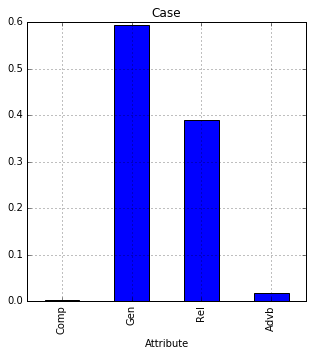

Person
  Attribute  Count      Norm
0         1      5  0.037037
1         3    129  0.955556
2         2      1  0.007407


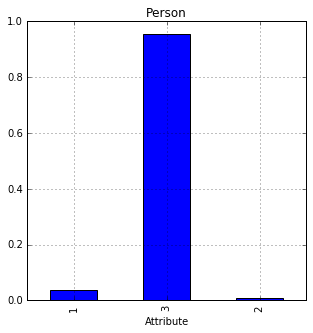

Voice
  Attribute  Count     Norm
0       Cau     57  0.59375
1      Pass     39  0.40625


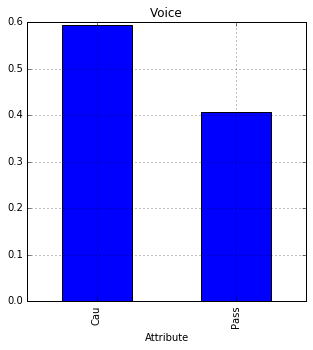

Aspect
  Attribute  Count      Norm
0      Prog     14  0.119658
1      Perf    103  0.880342


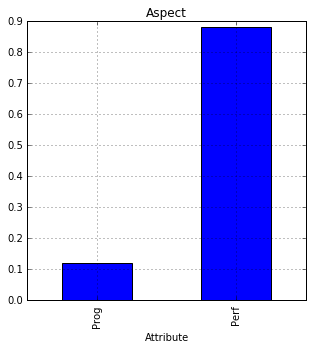

In [145]:
attr_only_spec = {}
for attr in ['Animacy', 'Aspect', 'Case', 'Definite', 'Degree',\
                         'Evident', 'Gender', 'Mood', 'NumType', 'Number',\
                         'Person', 'Polarity', 'Polite', 'PronType', 'Tense',\
                         'VerbForm', 'Voice']:
    spec_dict = {}
    for k,v in ch_attr_count.items():
        if k.find(attr) != -1:
            new_key = k[k.find(':')+1:] # taking second part of name, attribute specific
            spec_dict[new_key] = v
    if len(spec_dict) > 1: # only attributes with more than 1 value
        attr_only_spec[attr] = spec_dict
for k,v in attr_only_spec.items():  
    df = attr_statistic(attr_only_spec[k])
    print(k)
    print(df)
    plot_statistic(df, 'Attribute', k)

In [146]:
dep_statistic(ch_dep_count)

,Dep,Count,Norm
0,foreign,29,0.002414
1,case:aspect,117,0.009740
2,cc,182,0.015152
3,iobj,3,0.000250
4,nmod:tmod,134,0.011156
5,ccomp,218,0.018149
6,nsubjpass,22,0.001832
7,nmod,1732,0.144189
8,csubj,24,0.001998
9,conj,323,0.026890


In [153]:
def parse_dependencies(path_to_file):
    with open(path_to_file, 'r', encoding = "utf-8") as f:
        lines = f.readlines()
        deps = []
        sentence = {}
        for line in lines:
            line = line.strip().split("\t")
            if line[0].isdigit():
                if int(line[0]) == 1:
                    if sentence:
                        deps.append(sentence)
                    sentence = {}
                if int(line[6]) in sentence:
                    sentence[int(line[6])].append(int(line[0]))
                else:
                    sentence[int(line[6])] = [int(line[0])]
        return deps

    
def is_projective(deps, word_id, lower_bound, upper_bound):
    if word_id < lower_bound or word_id > upper_bound:
        return False
    if word_id in deps.keys():
        for word in deps[word_id]:
            if word < word_id:
                return is_projective(deps, word, lower_bound, min(upper_bound, word_id))
            else:
                return is_projective(deps, word, max(lower_bound, word_id), upper_bound)
    return True


def get_non_projective_sents(file_path):
    deps = parse_dependencies(file_path)
    sentences = []
    ids = list()
    for i in range(len(deps)):
        if not is_projective(deps[i], 0, -1, float("inf")):
            sentences.append(i)
    return sentences, len(deps)

def get_projective_sents(file_path):
    deps = parse_dependencies(file_path)
    sentences = []
    ids = list()
    for i in range(len(deps)):
        if is_projective(deps[i], 0, -1, float("inf")):
            sentences.append(i)
    return sentences, len(deps)

def get_all_sentences(file):
    res = list()
    ids = list()
    i = 0
    sentance = ""
    for line in file:
        splitted = line.split("\t")
        if splitted[0].isdigit():
            sentance = sentance + splitted[1] + " "
        elif not line.startswith("#"):
            ids.append(i)
            res.append(sentance)
            sentance = ""
            i = i + 1
    return res, ids

def calc_uas_and_las(predicted_file, gold_file):
    gold_sents = [nltk.parse.DependencyGraph(s) for s in read_sents(gold_file)]
    parsed_sents = [nltk.parse.DependencyGraph(s) for s in read_sents(predicted_file)]
    de = nltk.parse.DependencyEvaluator(parsed_sents, gold_sents)
    return de.eval()

def read_sents(file):
    sentences = []
    sentence = []
    for line in file:
        line = line.strip()
        if line.startswith("#"):
            continue
        elif len(line) < 1:
            if sentence is not None and len(sentence):
                sentences.append("\n".join(sentence))
                sentence = []
        else:
            sentence.append(line)
    return sentences

# Русский

In [154]:
rus_train, deps = get_non_projective_sents("UD_Russian/ud-train.conllu")
print('Кол-во проективных деревьев: {}'.format(deps - len(rus_train)))
print('Кол-во не проективных деревьев: {}'.format(len(rus_train)))

Кол-во проективных деревьев: 4004
Кол-во не проективных деревьев: 24


In [155]:
print('==== Projective sentences ====')
rus_projective_train, projective_deps = get_projective_sents("UD_Russian/ud-train.conllu")
connl_rustrain = open("UD_Russian/ud-train.conllu", "r", encoding = "utf-8")
connl_file_rustrain = connl_rustrain.readlines()
connl_rustrain.close()
rus_train_sentences, rus_sents_ids = get_all_sentences(connl_file_rustrain)
for i in rus_projective_train:
    print('Sentence id: {}, sentence text: {}'.format(rus_sents_ids[i], rus_train_sentences[i]))

==== Projective sentences ====
Sentence id: 0, sentence text: Во время битвы между силами Магнето и героями , кто восстановил свои воспоминания , мутант Лайла Миллер смогла восстановить воспоминания Магнето об оригинальной реальности . 
Sentence id: 1, sentence text: Когда он будет заполнен , у драконов появляется возможность перейти в режим ярости , силе которого не способен сопротивляться ни один противник в игре . 
Sentence id: 2, sentence text: Главная пара используется весь сезон и имеет значения 1 : 27454 , 1 : 41762 , 1 : 45717 и 1 : 42064 . 
Sentence id: 3, sentence text: Этим же постановлением устанавливалась окружная и районная система деления края . 
Sentence id: 4, sentence text: Позже вышел имеющий силу Закона Указ Президента Республики Казахстан от 15 сентября 1995 г . 
Sentence id: 5, sentence text: Но в 1920 году он переехал во дворец Дорн , где прожил до своей смерти в 1941 году . 
Sentence id: 6, sentence text: Придаток в мужском початке , сидячий , загнутый или закру

In [112]:
rus_test, deps = get_non_projective_sents("UD_Russian/ud-test.conllu")
print('Кол-во проективных деревьев: {}'.format(deps - len(rus_test)))
print('Кол-во не проективных деревьев: {}'.format(len(rus_test)))

Кол-во проективных деревьев: 497
Кол-во не проективных деревьев: 1


## LAS/UAS

In [107]:
connl_rustest = open("UD_Russian/ud-test.conllu", "r", encoding = "utf-8")
connl_rustegged = open("results/russian_tagger.conll", "r", encoding = "utf-8")
connl_ruswithouttegged = open("results/russian_without_tagger.conll", "r", encoding = "utf-8")
connl_file_rustest = connl_rustest.readlines()
connl_file_rustegged = connl_rustegged.readlines()
connl_file_ruswithouttegged = connl_ruswithouttegged.readlines()
connl_rustest.close()
connl_rustegged.close()
connl_ruswithouttegged.close()

In [108]:
las, uas = calc_uas_and_las(connl_file_rustest, connl_file_rustegged)
print('UAS: {}, LAS: {}'.format(las, uas))

UAS: 0.8304189206189457, LAS: 0.7131714681091961


C:\Users\Denis\Anaconda3\envs\tensorflow\lib\site-packages\nltk\parse\dependencygraph.py:378: UserWarning: The graph doesn't contain a node that depends on the root element.
  "The graph doesn't contain a node "


In [109]:
las, uas = calc_uas_and_las(connl_file_rustest, connl_file_ruswithouttegged)
print('UAS: {}, LAS: {}'.format(las, uas))

UAS: 0.7891558686627249, LAS: 0.6759340797584602


C:\Users\Denis\Anaconda3\envs\tensorflow\lib\site-packages\nltk\parse\dependencygraph.py:378: UserWarning: The graph doesn't contain a node that depends on the root element.
  "The graph doesn't contain a node "


# Китайский

In [114]:
ch_train, deps = get_non_projective_sents("UD_Chinese/ud-train.conllu")
print('Кол-во проективных деревьев: {}'.format(deps - len(ch_train)))
print('Кол-во не проективных деревьев: {}'.format(len(ch_train)))

Кол-во проективных деревьев: 3995
Кол-во не проективных деревьев: 1


In [156]:
print('==== Projective sentences ====')
ch_projective_train, projective_deps = get_projective_sents("UD_Chinese/ud-train.conllu")
connl_chtrain = open("UD_Chinese/ud-train.conllu", "r", encoding = "utf-8")
connl_file_chtrain = connl_chtrain.readlines()
connl_chtrain.close()
ch_train_sentences, ch_sents_ids = get_all_sentences(connl_file_chtrain)
for i in ch_projective_train:
    print('Sentence id: {}, sentence text: {}'.format(ch_sents_ids[i], ch_train_sentences[i]))

==== Projective sentences ====
Sentence id: 0, sentence text: 看似 簡單 , 只 是 二 選 一 做 決擇 , 但 其實 他們 代表 的 是 你 周遭 的 親朋 好友 , 試 著 給 你 不同 的 意見 , 但 追根究底 , 最後 決定 的 還是 自己 . 
Sentence id: 1, sentence text: 其 便當 都是 買來 的 , 就算 加熱 也是 由 媽媽 負責 ( 後來 揭曉 其實 是 避免 帶來 厄運 ) , 父親 則 在 電視 台 上班 . 
Sentence id: 2, sentence text: 這 次 遊行 最大 的 特色 , 在 於 越來越 多 年輕 人 上街 遊行 , 而且 當中 不乏 行動 激烈 的 躁 少年 . 
Sentence id: 3, sentence text: 懷孕 期 為 421 至 457 日 . 
Sentence id: 4, sentence text: 婷婷 向 昏迷 中 的 婆婆 訴說 , 為 什麼 生活 會 與 她 想像 的 不 一樣 . 
Sentence id: 5, sentence text: 就算 數論 的 應用 被 找到 了 , 也 不會 有 人 會 因 此 罷黜 這 一 數學 的 皇后 . 
Sentence id: 6, sentence text: 一中 商圈 另 一 特色 為 同 類型 商店 會 聚集 , 短短 的 育才 街 聚集 了 十數 家 知名 眼鏡 連鎖 店 , 而 體育 用品 店 沿著 太平 路 連成 一 線 , 在 激烈 競爭 下 價格 比 外地 便宜 不少 , 貨 比 三 家 更 增加 購物 樂趣 . 
Sentence id: 7, sentence text: 《 一 代 女皇 》 開錄 當日 掌鏡 者 是 導播 出身 的 當時 中視 節目 部 經理 王 世綱 . 
Sentence id: 8, sentence text: 我們 只 希望 , 藉著 這 個 歷史 上 真實 人物 的 一 生 , 利用 一些 稗官野史 的 片段 資料 , 再 加上 一些 善意 改編 的 部分 情節 , 而 能 帶給 觀眾 一些 啟示 . 」 
Sentence id: 9, sentence text: 當時 

In [115]:
ch_test, deps = get_non_projective_sents("UD_Chinese/ud-test.conllu")
print('Кол-во проективных деревьев: {}'.format(deps - len(ch_test)))
print('Кол-во не проективных деревьев: {}'.format(len(ch_test)))

Кол-во проективных деревьев: 499
Кол-во не проективных деревьев: 0


## LAS/UAS

In [101]:
connl_chtest = open("UD_Chinese/ud-test.conllu", "r", encoding = "utf-8")
connl_chtegged = open("results/chinese_tagger.conll", "r", encoding = "utf-8")
connl_chwithouttegged = open("results/chinese_without_tagger.conll", "r", encoding = "utf-8")
connl_file_chtest = connl_chtest.readlines()
connl_file_chtegged = connl_chtegged.readlines()
connl_file_chwithouttegged = connl_chwithouttegged.readlines()
connl_chtest.close()
connl_chtegged.close()
connl_chwithouttegged.close()

In [102]:
las, uas = calc_uas_and_las(connl_file_chtest, connl_file_chtegged)
print('UAS: {}, LAS: {}'.format(las, uas))

UAS: 0.7726215849641542, LAS: 0.6744816895950397


C:\Users\Denis\Anaconda3\envs\tensorflow\lib\site-packages\nltk\parse\dependencygraph.py:378: UserWarning: The graph doesn't contain a node that depends on the root element.
  "The graph doesn't contain a node "


In [103]:
las, uas = calc_uas_and_las(connl_file_chtest, connl_file_chwithouttegged)
print('UAS: {}, LAS: {}'.format(las, uas))

UAS: 0.812536330168572, LAS: 0.7280565781825228


C:\Users\Denis\Anaconda3\envs\tensorflow\lib\site-packages\nltk\parse\dependencygraph.py:378: UserWarning: The graph doesn't contain a node that depends on the root element.
  "The graph doesn't contain a node "
